In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib notebook

# Logging visualization

This notebook operates under the assumption that a `TARDIS` `numba_montecarlo` run has already been completed, with the `log_decorator` enabled for `single_packet_loop`. It then visualizes the progress of packets through shells, depicting different interactions.

TODO: 
- animate packet progress
- include run of TARDIS in the notebook

In [2]:
# TODO: read these in from config file that was used. These are just from TARDIS example.

velocities = np.linspace(1.1e4, 20000, 21)  # km / s
velocities *= 1e5  # cm / s
t_explosion = 10  # days
t_explosion *= 24*60*60 # seconds
radii = velocities * t_explosion

In [3]:
log_file_path = 'sample_montecarlo_log.log'  # change based on where the log file is

In [8]:
def assign_val(string):
    """
    Maps different interactions to a representation that allows for easier plotting.
    """
    if 'LINE' in string:
        return 2
    elif 'BOUNDARY' in string:
        return 1
    else:
        return 0

In [15]:
def plot_packet_from_logs(log_file_path, max_plotted=500, temp_inner=12000):
    """
    Used to track the progress of single packets.
    log_file_path: name of log.
    
    Inputs:
        log_file_path (string): path to log file.
        max_plotted (int, default 500): max number of packets that are plotted.
        
    TODO: get t_inner from model.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.set_ylim(-1.9e15, 1.9e15)
    ax.set_xlim(-1.9e15, 1.9e15)
    ax.set_xlabel('Distance (cm)', fontsize=18)
    ax.set_ylabel('Distance (cm)', fontsize=18)
    
    temps = np.power(radii/radii[0], -1/3) * temp_inner # T scales as r^-1/3
    
    def plot_shells():
        norm = mpl.colors.Normalize(vmin=min(temps), vmax=max(temps))
        cmap = mpl.cm.get_cmap('magma')
        for i, r in enumerate(radii[::-1]): # need to fix this
            temp = temps[::-1][i]
            color = cmap(norm(temp))
            ax.add_patch(mpl.patches.Circle((0, 0), r, edgecolor='black',
                                                facecolor=color, alpha=0.5)) # need to do outside in?
    plot_shells()
    xs = [] # n steps x m particles
    ys = []
    interactions_all = []
    ticker = 0
    with open(log_file_path, "r") as file:
        for line in file:
            if 'Output' in line and ticker < max_plotted:
                output = line.split('Output: ')[1][:-2]
                
                interactions = output.split('<')[1:-1]
                interactions = [assign_val(interaction) for interaction in interactions]
                last = output.split('<')[-1].split('>')[0]
                interactions += [assign_val(last)]
            
                r_track_distance = eval('[' + output.split('[')[-1][:-1])
                if None in r_track_distance or 'stop' in r_track_distance:
                    r_track_distance = r_track_distance[0]
                rel_output = output.split(', [<InteractionType.BOUNDARY')[0]
                formatted = rel_output + ')'
                r_track_nu, r_track_mu, r_track_r = eval(formatted)
                r_track_r = np.array(r_track_r)
                r_track_distance = np.array(r_track_distance)
                angle = np.cumsum(np.arccos((r_track_r[:-1] ** 2 + r_track_r[
                                                               1:] ** 2 - r_track_distance[
                                                                          1:] ** 2) / (
                                                    2 * r_track_r[:-1] * r_track_r[
                                                                         1:])))
                x, y = np.sin(angle) * r_track_r[1:], np.cos(angle) * r_track_r[1:]
                x = np.hstack(([0], x))
                y = np.hstack((r_track_r[0], y))
                ax.plot([x[0]], [y[0]], marker='o', color='gray')
#                 ax.plot(x, y, color='gray', alpha=.2)
    # have to load into one larger array
#                 plt.scatter(x[interactions==1], y[interactions==1], marker='o')
#                 plt.scatter(x[interactions==2], y[interactions==2], marker='+')
                xs += [x]
                ys += [y]
                interactions_all += [interactions]
                ticker += 1
                interactions = np.array(interactions)
        try:
#             ax.plot(x, y, marker='x', color='goldenrod', alpha=.2, label='Packet paths')
#             ax.plot(x, y, color='red', label='Last valid packet')
#             ax.scatter(x[interactions==1], y[interactions==1], marker='o', color='red', 
#                        label='Boundary interaction', zorder=10)
#             ax.scatter(x[interactions==2], y[interactions==2], marker='+', color='red',
#                        s=75, label='Line interaction', zorder=10)
#             ax.plot([x[0]], [y[0]], marker='o', color='gray', label='Starting point')

            # ignore interactions for now
#             ipdb.set_trace()
            for i in range(len(xs)):
                scat = ax.scatter(xs[i], ys[i], zorder=10)
            plt.legend(fontsize=14, loc='upper right')
            m = plt.cm.ScalarMappable(cmap='plasma')

            cbar = fig.colorbar(m, ax=ax, 
                         boundaries=np.linspace(min(temps), max(temps), 200))
            cbar.set_label(label='Temperature (K)', size=18)

        except UnboundLocalError:
            print('No packets traveled!')
#     animation = FuncAnimation(fig, update, interval=10)
#     plt.savefig('tardis_viz.pdf')
    plt.show()
    return xs, ys, interactions

<IPython.core.display.Javascript object>


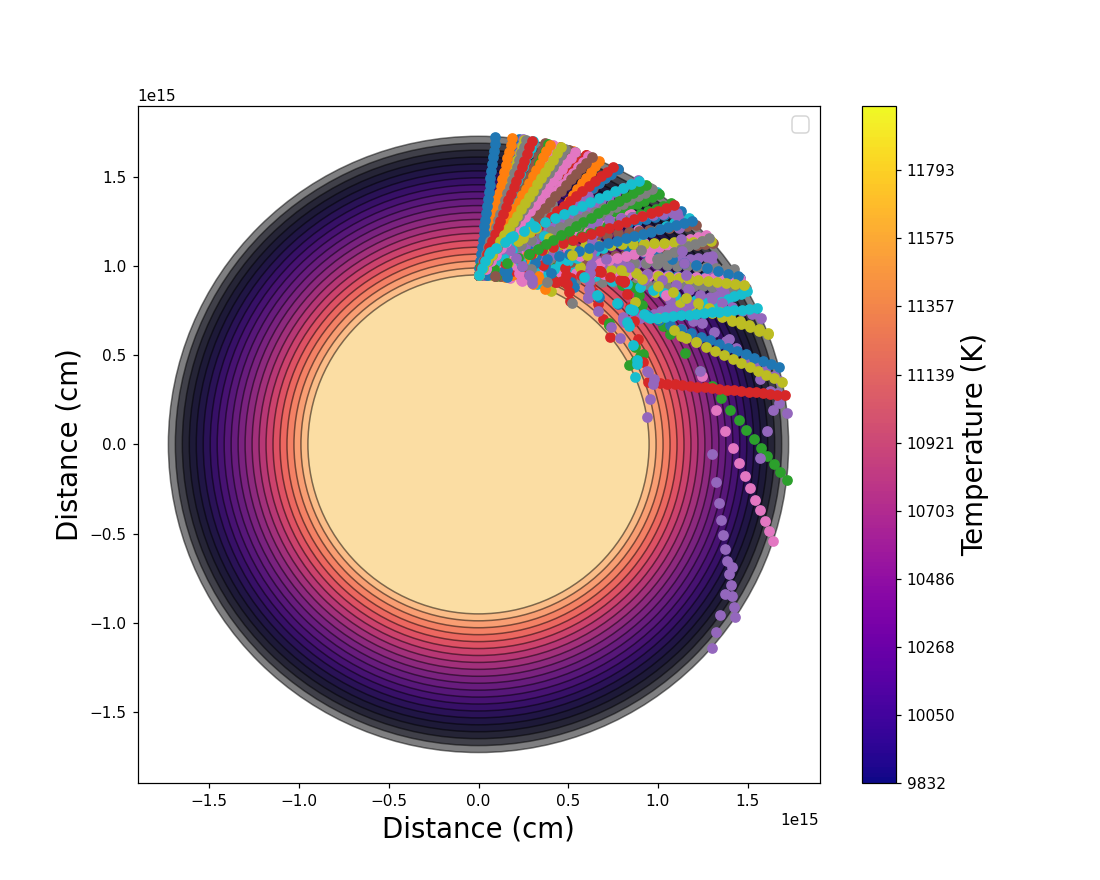

No handles with labels found to put in legend.
<ipython-input-16-c58277c09fb9>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  xs, ys, interactions = np.array(plot_packet_from_logs(log_file_path))


In [16]:
xs, ys, interactions = np.array(plot_packet_from_logs(log_file_path))

<IPython.core.display.Javascript object>


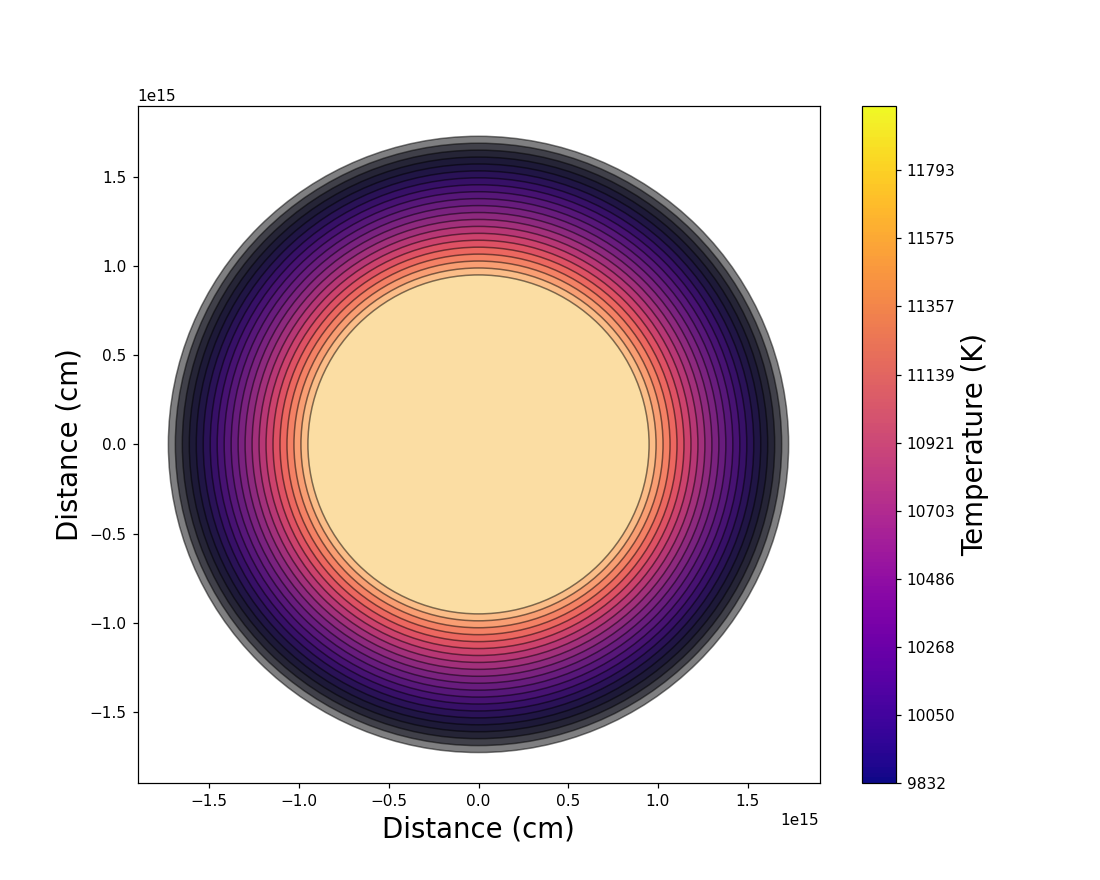

(array([0.00000000e+00, 1.15642634e+13, 2.30915348e+13, 3.45861553e+13,
       4.60518031e+13, 5.74916160e+13, 6.89082891e+13, 8.03041508e+13,
       9.16812237e+13, 1.03041274e+14, 1.14385850e+14, 1.25716318e+14,
       1.37033885e+14, 1.48339624e+14, 1.59634490e+14, 1.70919338e+14,
       1.82194935e+14, 1.93461971e+14, 2.04721068e+14, 2.15972791e+14,
       2.27217649e+14]), array([9.50400000e+14, 9.89212407e+14, 1.02790066e+15, 1.06647933e+15,
       1.10496076e+15, 1.14335548e+15, 1.18167254e+15, 1.21991975e+15,
       1.25810390e+15, 1.29623092e+15, 1.33430601e+15, 1.37233374e+15,
       1.41031818e+15, 1.44826291e+15, 1.48617116e+15, 1.52404578e+15,
       1.56188935e+15, 1.59970420e+15, 1.63749239e+15, 1.67525584e+15,
       1.71299625e+15]))


In [7]:
class Animate(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    
    xs = []
    ys = []
    interactions_all = []
    
    def __init__(self, log_file_path, temp_inner=12000, max_plotted=500):
      
        velocities = np.linspace(1.1e4, 20000, 21)  # km / s
        velocities *= 1e5  # cm / s
        t_explosion = 10  # days
        t_explosion *= 24*60*60 # seconds
        radii = velocities * t_explosion
        
        
        self.stream = self.data_stream()
        self.max_plotted = max_plotted
        # Setup the figure and axes...
        self.fig = plt.figure(figsize=(10, 8))
        self.ax = plt.gca()
        self.ax.set_ylim(-1.9e15, 1.9e15)
        self.ax.set_xlim(-1.9e15, 1.9e15)
        self.ax.set_xlabel('Distance (cm)', fontsize=18)
        self.ax.set_ylabel('Distance (cm)', fontsize=18)
        self.temps = np.power(radii/radii[0], -1/3) * temp_inner # T scales as r^-1/3
        m = plt.cm.ScalarMappable(cmap='plasma')
        cbar = self.fig.colorbar(m, ax=self.ax, 
                         boundaries=np.linspace(min(self.temps), max(self.temps), 200))
        cbar.set_label(label='Temperature (K)', size=18)

        
        self.xs, self.ys, self.interactions_all = self.read_log_file(log_file_path)
        self.plot_shells()
        print(next(self.stream))
#         Then setup FuncAnimation.
        self.ani = FuncAnimation(self.fig, self.update, 
                                          init_func=self.setup_plot, blit=True)

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        print('setting')
        x, y, interaction = next(self.stream)
        self.scat = self.ax.scatter(x, y, zorder=100)
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

    def data_stream(self):
        """Generate a random walk (brownian motion). Data is scaled to produce
        a soft "flickering" effect."""
        ticker = 0
        while ticker < len(self.xs):
            x, y = self.xs[ticker], self.ys[ticker]
            ticker += 1
            yield x, y

    def update(self, i):
        """Update the scatter plot."""
        print(i)
        x, y, interaction = next(self.stream)
        

        # Set x and y data...
        self.scat.set_offsets(np.c_[x, y])
        # Set sizes...
#         self.scat.set_sizes(300 * abs(data[:, 2])**1.5 + 100)
        # Set colors..
#         self.scat.set_array(data[:, 3])

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,
    
    def plot_shells(self):
        norm = mpl.colors.Normalize(vmin=min(self.temps), vmax=max(self.temps))
        cmap = mpl.cm.get_cmap('magma')
        for i, r in enumerate(radii[::-1]): # need to fix this
            temp = self.temps[::-1][i]
            color = cmap(norm(temp))
            self.ax.add_patch(mpl.patches.Circle((0, 0), r, edgecolor='black',
                                                facecolor=color, alpha=0.5,
                                                zorder=-1)) # need to do outside in?
    
    def read_log_file(self, log_file_path):
        xs = [] # n steps x m particles
        ys = []
        interactions_all = []
        ticker = 0
        with open(log_file_path, "r") as file:
            for line in file:
                if 'Output' in line and ticker < self.max_plotted:
                    output = line.split('Output: ')[1][:-2]

                    interactions = output.split('<')[1:-1]
                    interactions = [assign_val(interaction) for interaction in interactions]
                    last = output.split('<')[-1].split('>')[0]
                    interactions += [assign_val(last)]

                    r_track_distance = eval('[' + output.split('[')[-1][:-1])
                    if None in r_track_distance or 'stop' in r_track_distance:
                        r_track_distance = r_track_distance[0]
                    rel_output = output.split(', [<InteractionType.BOUNDARY')[0]
                    formatted = rel_output + ')'
                    r_track_nu, r_track_mu, r_track_r = eval(formatted)
                    r_track_r = np.array(r_track_r)
                    r_track_distance = np.array(r_track_distance)
                    angle = np.cumsum(np.arccos((r_track_r[:-1] ** 2 + r_track_r[
                                                                   1:] ** 2 - r_track_distance[
                                                                              1:] ** 2) / (
                                                        2 * r_track_r[:-1] * r_track_r[
                                                                             1:])))
                    x, y = np.sin(angle) * r_track_r[1:], np.cos(angle) * r_track_r[1:]
                    x = np.hstack(([0], x))
                    y = np.hstack((r_track_r[0], y))
                    xs += [x]
                    ys += [y]
                    interactions_all += [interactions]
                    ticker += 1
        return xs, ys, interactions_all

if __name__ == '__main__':
    a = Animate(log_file_path)
    plt.show()

# Outstanding questions
- how many to animate?
    - Look clean: but also have it contain all relevant info
    - \> 2 dozen will be tough
    - Release packets in blocks; gray them out after moving, fade back in at end. summary of all blocks at end
- animate kwarg?
- how to make it look? Colors, etc.
    - GUI color scheme for temperature — but flipped
    - Decrease alpha values, perhaps?
    - black + gray for packets
- step through with each interaction? how many interactions does a packet usually have?
    - look into this. depends on whether pure scattering, macroatom. most people use macroatom
- color code shell by temp: use same color scheme as GUI. include temperature scale?
    - create temp_scale function
- hold the packets in the center
- gray out packets as they move into photosphere
- different modes, different things (assumptions, etc.)
    - nebular!
- darker photosphere?
- arrows on packets that make it to outside...or note what goes into the spectrum somehow
- how to demonstrate interactions?
    - use different color + different symbol for an interaction — test out bc different colors, diff shells
    - probably stick with symbols
- 3D!
    - Use plotly
    - 3D spherically symmetric thing of start then actually move in 2D.
    - d3.js
- Add GIF to PRs

- make a TEP

In [8]:
xs

array([array([0.00000000e+00, 1.15642634e+13, 2.30915348e+13, 3.45861553e+13,
       4.60518031e+13, 5.74916160e+13, 6.89082891e+13, 8.03041508e+13,
       9.16812237e+13, 1.03041274e+14, 1.14385850e+14, 1.25716318e+14,
       1.37033885e+14, 1.48339624e+14, 1.59634490e+14, 1.70919338e+14,
       1.82194935e+14, 1.93461971e+14, 2.04721068e+14, 2.15972791e+14,
       2.27217649e+14]),
       array([0.00000000e+00, 1.84524654e+13, 3.67557262e+13, 3.67741343e+13,
       3.68638730e+13, 6.20040521e+13, 9.59847225e+13, 1.45855275e+14]),
       array([0.00000000e+00, 1.57751055e+12, 3.50949254e+12]),
       array([0.00000000e+00, 1.72429322e+13, 2.02643641e+13, 2.86210810e+13,
       3.33240723e+13, 3.69095449e+13, 6.35586490e+13, 1.34205852e+14,
       1.38786085e+14, 1.45581270e+14, 2.31702617e+14, 3.18322982e+14,
       3.99618654e+14, 4.63269404e+14, 5.28290511e+14, 6.23050162e+14,
       6.36519281e+14, 6.64430281e+14, 6.96265867e+14, 7.35482442e+14]),
       array([0.00000000e+00, 4.18

<IPython.core.display.Javascript object>


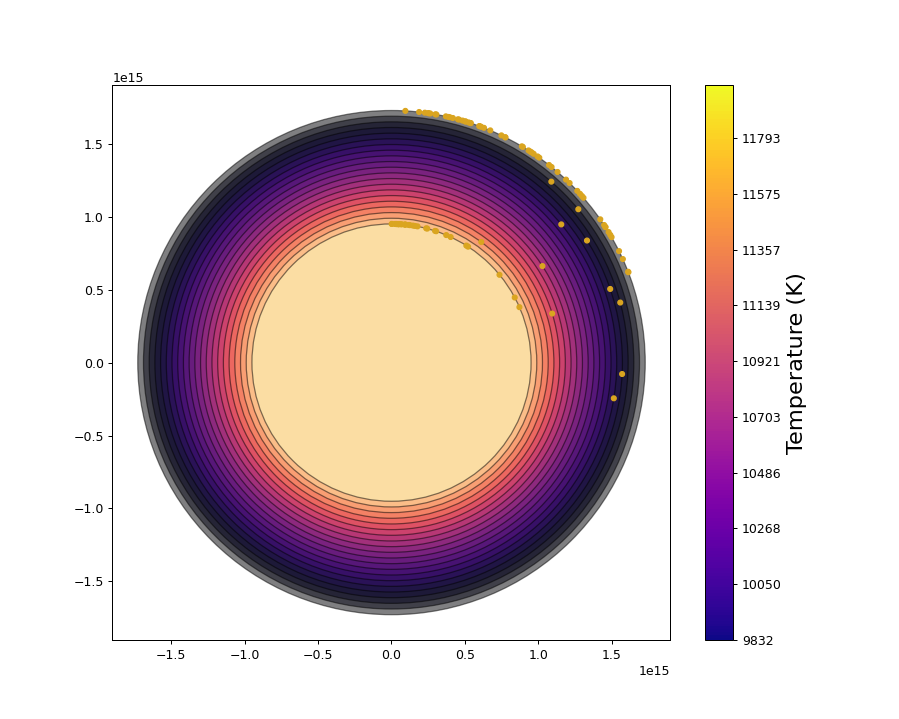

In [98]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, numpoints=50, temp_inner=12000, interp_iterations=3):
        self.numpoints = numpoints
        self.interp_iterations = interp_iterations
        self.temps = np.power(radii/radii[0], -1/3) * temp_inner # T scales as r^-1/3
        self.xs = xs.copy()
        self.ys = ys.copy()
        self.xs = self.prep_array(self.xs)
        self.ys = self.prep_array(self.ys)
#         self.interpolate()

        self.stream = self.data_stream()

        # Setup the figure and axes...
        self.fig = plt.figure(figsize=(10, 8))
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=305, 
                                          init_func=self.setup_plot, blit=True,
                                          repeat=False)
        
    def save(self, name):
        self.ani.save(name)

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
#         x, y, s, c = next(self.stream).T
#         self.scat = self.ax.scatter(x, y, c=c, s=s, vmin=0, vmax=1,
#                                     cmap="jet", edgecolor="k")
        self.ax = plt.gca()
        self.ax.set_ylim(-1.9e15, 1.9e15)
        self.ax.set_xlim(-1.9e15, 1.9e15)
        m = plt.cm.ScalarMappable(cmap='plasma')
        cbar = self.fig.colorbar(m, ax=self.ax, 
                         boundaries=np.linspace(min(self.temps), max(self.temps), 200))
        cbar.set_label(label='Temperature (K)', size=18)
        self.plot_shells()
        self.scat = self.ax.scatter([], [], c='goldenrod')
#         self.ax.axis([-10, 10, -10, 10])
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,
    
    def interpolate(self):
        for iteration in range(self.interp_iterations):
            print('iterating')
            for i in range(len(self.xs)):
                new_val = (self.ys[2 * i - 1] + self.ys[2 * i])/2
                self.ys = np.insert(self.ys, 2 * i, new_val)
                
                new_val = (self.xs[2 * i - 1] + self.xs[2 * i])/2
                self.xs = np.insert(self.xs, 2 * i, new_val)
            self.xs = self.xs[1:]
            self.ys = self.ys[1:]

    def data_stream(self):
        """Generate a random walk (brownian motion). Data is scaled to produce
        a soft "flickering" effect."""
        xy = (np.random.random((self.numpoints, 2))-0.5)*10
        s, c = np.random.random((self.numpoints, 2)).T
        ticker = 0 
        while ticker < len(xs):
            xy += 0.03 * (np.random.random((self.numpoints, 2)) - 0.5)
            s += 0.05 * (np.random.random(self.numpoints) - 0.5)
            c += 0.02 * (np.random.random(self.numpoints) - 0.5)
            ticker += 1
            yield np.c_[xy[:,0], xy[:,1], s, c]
            
    def prep_array(self, arr):
        full_array = []
        for j in range(52):
            new_arr = []
            for i in range(len(arr)):
                if j >= len(arr[i]):
                    new_arr += [arr[i][-1]]
                else:
                    new_arr += [arr[i][j]]
            full_array.append(new_arr)
        return full_array
    
    def update(self, i):
        """Update the scatter plot."""
        data = next(self.stream)

        # Set x and y data...
#         self.scat.set_offsets(data[:, :2])
        self.scat.set_offsets(np.c_[self.xs[i], self.ys[i]])
        # Set sizes...
        self.scat.set_sizes(15 * np.ones(len(self.xs[i])))
        # Set colors..
#         self.scat.set_array(data[:, 3])

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,
    
    def plot_shells(self):
        norm = mpl.colors.Normalize(vmin=min(self.temps), vmax=max(self.temps))
        cmap = mpl.cm.get_cmap('magma')
        for i, r in enumerate(radii[::-1]): # need to fix this
            temp = self.temps[::-1][i]
            color = cmap(norm(temp))
            self.ax.add_patch(mpl.patches.Circle((0, 0), r, edgecolor='black',
                                                facecolor=color, alpha=0.5, zorder=-1)) # need to do outside in?


if __name__ == '__main__':
    a = AnimatedScatter()
#     a.save('scatter.mp4')
    plt.show()

In [83]:
for i in range(1):
    print(i)

0


In [16]:
x = np.arange(1, 10, 3)
y = np.interp(np.arange(1,7, ),)

In [106]:
x = xs[0].copy()

In [105]:
x

array([6.75599369e+13, 0.00000000e+00, 8.10148280e+12, 1.62029656e+13,
       2.47644759e+13, 3.33259863e+13, 4.20999102e+13, 5.08738340e+13,
       5.98551716e+13, 6.88365091e+13, 7.80276711e+13, 8.72188332e+13,
       9.66218885e+13, 1.06024944e+14, 1.15641423e+14, 1.25257903e+14,
       1.30188888e+14, 1.35119874e+14])

In [111]:
xs[0]

array([0.00000000e+00, 1.62029656e+13, 3.33259863e+13, 5.08738340e+13,
       6.88365091e+13, 8.72188332e+13, 1.06024944e+14, 1.25257903e+14,
       1.35119874e+14])

In [109]:
 def interpolate(x, iterations):
    for iteration in range(iterations):
        for i in range(len(x)):

            new_val = (x[2 * i - 1] + x[2 * i])/2
            x = np.insert(x, 2 * i, new_val)
    return x[1:]

In [112]:
interpolate(x, 2)

array([6.75599369e+13, 3.37799685e+13, 0.00000000e+00, 4.05074140e+12,
       8.10148280e+12, 1.21522242e+13, 1.62029656e+13, 2.04837208e+13,
       2.47644759e+13, 2.90452311e+13, 3.33259863e+13, 3.77129482e+13,
       4.20999102e+13, 4.64868721e+13, 5.08738340e+13, 5.53645028e+13,
       5.98551716e+13, 6.43458403e+13, 6.88365091e+13, 7.34320901e+13,
       7.80276711e+13, 8.26232522e+13, 8.72188332e+13, 9.19203608e+13,
       9.66218885e+13, 1.01323416e+14, 1.06024944e+14, 1.10833184e+14,
       1.15641423e+14, 1.20449663e+14, 1.25257903e+14, 1.27723396e+14,
       1.30188888e+14, 1.32654381e+14, 1.35119874e+14])

In [45]:
xs[99]

array([0.00000000e+00, 1.95711982e+13, 3.89646379e+13, 5.82037696e+13,
       6.50940429e+13, 9.77620278e+13, 1.46744779e+14, 1.77534392e+14,
       1.79352024e+14, 1.93295133e+14, 2.55858880e+14, 3.14727111e+14,
       3.70746422e+14, 4.24497303e+14, 4.76396957e+14, 5.26756253e+14,
       5.75813562e+14, 6.23755961e+14, 6.70733143e+14, 7.16866846e+14,
       7.62257464e+14, 8.06988795e+14, 8.51131521e+14, 8.94745821e+14])

In [73]:
full_xs = []
for j in range(52):
    new_xs = []
    for i in range(len(xs)):
        if j >= len(xs[i]):
            new_xs += [max(xs[i])]
        else:
            new_xs += [xs[i][j]]
    full_xs.append(new_xs)

In [78]:
full_xs[0]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [87]:
interactions

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])